### Random Forest Classification (RF) Experiment

In [1]:
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from preprocessing import prepare_data

random_state = 42
results = []
partial_save_path = "results/rf_partial_results.csv"

### 1. Load Data

In [2]:
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

### 2. Prepare Data for TREE Models

In [4]:
out_train_init = prepare_data(
    train_df,
    mode="tree",
    training=False,
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"]

out_test = prepare_data(
    test_df,
    mode="tree",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for trees. Shape: {X_test.shape}")

Test set prepared for trees. Shape: (555719, 13)


### 3. Define Experiment Parameters

In [ ]:
ratios_to_test = [None, 0.1, 0.5, 1.0]
resample_types_to_test = ["df_up", "df_down"] 

params_to_test = [
    {
        "name": "RF_Depth_10",
        "params": {"max_depth": 10},
    },
    {
        "name": "RF_Full_Depth",
        "params": {"max_depth": None},
    },
]

### 4. Run Experiment Loop

In [9]:
print("\nStarting Random Forest (FULL) experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    out_train = prepare_data(
        train_df,
        mode="tree",
        training=True,
        ratio=ratio,
        fit=False,
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            print(f"  SKIPPING {resample_type} for ratio={ratio} (no data)")
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        for p_info in params_to_test:
            model_name = p_info["name"]
            params = p_info["params"]
            start_k_time = time.time()

            print(f"    ⏳ Running {model_name} ...", end="")
            sys.stdout.flush()

            model = RandomForestClassifier(random_state=random_state, n_jobs=-1, **params)
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Metrics
            f1 = f1_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)

            results.append(
                {
                    "model": model_name,
                    "ratio": ratio,
                    "resample_type": resample_type.replace("df_",""),
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                }
            )

            print(
                f" done → F1={f1:.4f}, Recall={rec:.4f} | Time={time.time() - start_k_time:.1f}s"
            )
            sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")

print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")


Starting Random Forest (FULL) experiment loop...

[21:46:50] Starting ratio 1/7 → ratio=None
  [21:46:53] → Training on df_up (samples=1,296,675)
    ⏳ Running RF_Depth_10 ... done → F1=0.7128, Recall=0.5641 | Time=121.6s
    ⏳ Running RF_Full_Depth ... done → F1=0.8154, Recall=0.7072 | Time=131.8s
  [21:51:06] → Training on df_down (samples=1,296,675)
    ⏳ Running RF_Depth_10 ... done → F1=0.7128, Recall=0.5641 | Time=110.1s
    ⏳ Running RF_Full_Depth ... done → F1=0.8154, Recall=0.7072 | Time=133.3s
  💾 Saved intermediate results → results/rf_partial_results.csv
  ✅ Completed ratio=None in 8.3 min

[21:55:10] Starting ratio 2/7 → ratio=0.05
  [21:55:13] → Training on df_up (samples=1,353,627)
    ⏳ Running RF_Depth_10 ... done → F1=0.7753, Recall=0.7329 | Time=144.7s
    ⏳ Running RF_Full_Depth ... done → F1=0.8266, Recall=0.7324 | Time=177.6s
  [22:00:36] → Training on df_down (samples=157,626)
    ⏳ Running RF_Depth_10 ... done → F1=0.7283, Recall=0.7124 | Time=7.7s
    ⏳ Runnin

### 5. Show Final Results

In [10]:
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing Random Forest Models ---")
print(results_df.head(10))

results_df.to_csv("results/rf_results.csv", index=False)
print("\nSaved final results to results/rf_results.csv")


--- Top Performing Random Forest Models ---
            model  ratio resample_type  accuracy  precision    recall  \
17  RF_Full_Depth   0.30            up  0.998841   0.951836  0.737063   
5   RF_Full_Depth   0.05            up  0.998814   0.948671  0.732401   
13  RF_Full_Depth   0.20            up  0.998809   0.948036  0.731469   
9   RF_Full_Depth   0.10            up  0.998803   0.945247  0.732401   
21  RF_Full_Depth   0.50            up  0.998803   0.949029  0.729138   
25  RF_Full_Depth   1.00            up  0.998776   0.944209  0.725874   
1   RF_Full_Depth    NaN            up  0.998764   0.962563  0.707226   
3   RF_Full_Depth    NaN          down  0.998764   0.962563  0.707226   
7   RF_Full_Depth   0.05          down  0.998267   0.762900  0.799534   
4     RF_Depth_10   0.05            up  0.998361   0.823037  0.732867   

          f1  
17  0.830793  
5   0.826625  
13  0.825789  
9   0.825322  
21  0.824677  
25  0.820770  
1   0.815372  
3   0.815372  
7   0.780788  
4

### 6. Plot Results


Generating plots...


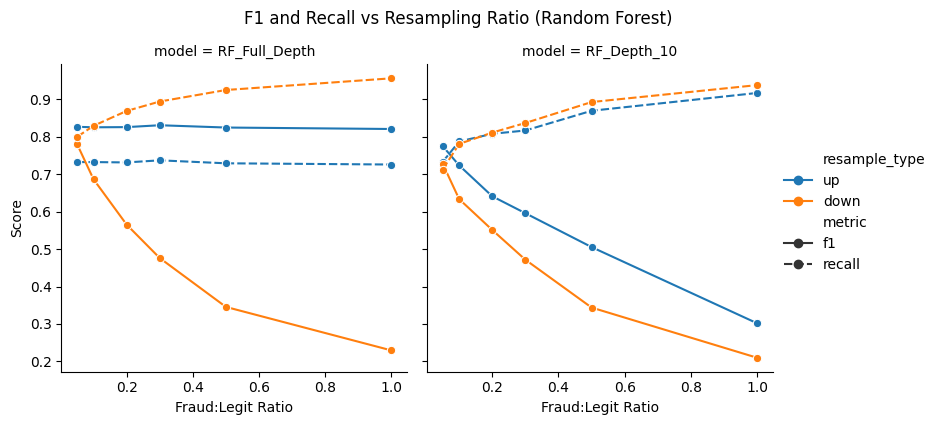


--- Mean Scores Summary ---
                                   precision  recall     f1
model         ratio resample_type                          
RF_Depth_10   0.05  down               0.745   0.712  0.728
                    up                 0.823   0.733  0.775
              0.10  down               0.533   0.781  0.634
                    up                 0.669   0.787  0.723
              0.20  down               0.417   0.811  0.551
                    up                 0.531   0.808  0.641
              0.30  down               0.328   0.837  0.472
                    up                 0.469   0.817  0.596
              0.50  down               0.213   0.893  0.344
                    up                 0.356   0.869  0.505
              1.00  down               0.118   0.938  0.210
                    up                 0.181   0.917  0.302
RF_Full_Depth 0.05  down               0.763   0.800  0.781
                    up                 0.949   0.732  0.827
           

In [11]:
print("\nGenerating plots...")


df_melt = results_df.melt(id_vars=['ratio', 'resample_type', 'model'], value_vars=['f1', 'recall'],
                            var_name='metric', value_name='score')

g_f1 = sns.relplot(
    data=df_melt,
    x="ratio",
    y="score",
    hue="resample_type",
    style="metric",
    col="model",
    kind="line",
    marker="o",
    height=4,
    aspect=1
)
g_f1.fig.suptitle("F1 and Recall vs Resampling Ratio (Random Forest)", y=1.05)
g_f1.set_axis_labels("Fraud:Legit Ratio", "Score")
g_f1.savefig("results/rf_f1_recall_plot.png")
plt.show()


# ---- Summary Table ----
summary = results_df.groupby(["model", "ratio", "resample_type"])[["precision", "recall", "f1"]].mean().round(3)
print("\n--- Mean Scores Summary ---")
print(summary)

print("\nPlots and summary complete.")